# 3D EFIT Rail Code in MPI

## Combined Zane structure, Eric MPI, My system

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import math
import time
import functools

#from distBox import distBox

import sys
#from mpi4py import MPI
from os import environ 
from typing import *                     
import matplotlib.animation as animation

In [2]:
#MPIComm = Union[MPI.Intracomm, MPI.Intercomm]
#mpi_comm = MPI.COMM_WORLD
#myid = mpi_comm.Get_rank()                                                         
#mpi_size = mpi_comm.Get_size()        
nprocs=1 #mpi_size
myid = 0

# for overlapping slabs:  
# # points per proc along z = npz = gh1/nproc (+2 to ghost boundaries)
# glob_index = loc_index-1 + npz*myid
# loc_index = glob_index - npz*myid + 1
# myid given glob_index = glob_index/npz = ghloc-2

# set Constants
AirCut = False
RailShape = True
figDPI = 600

#Dimmesnsion of simulation space in meters
length1 = 2
width1 = 0.1524 # 0.1524
height1 = 0.1524
cycles = 20

#Image Folder
imFolder = '/sciclone/scr10/dchendrickson01/EFIT/'
runName = 'RailRub'

#is the rail supported by 0, 1 or 2 ties
Ties = 0
Flaw = False

#Choose ferquency to be used for excitment
frequency = 16300
#frequency = 37139
frequency = 60000

#Run for 4 Cycles:
runtime = cycles / frequency 

#Forcing Function Location and type
# 1 for dropped wheel on top
# 2 for rubbing flange on side
# 3 for plane wave
FFunction = 2

#MATERIAL 1 ((steel))
pRatio1 = 0.29                                    #poission's ratio in 
yModulus1 = 200 * (10**9)                           #youngs modulus in pascals
rho1 = 7800                                        #density in kg/m^3

#Image Folder
if FFunction == 1:
    imFolder += 'TopHit/'
elif FFunction == 2:
    imFolder += 'RailSide/'
elif FFunction ==3:
    imFolder += 'Cube/'
elif FFunction ==4:
    imFolder += 'Temp/'

WheelLoad = 173000 #crane force in Neutons

#CALCULATED PARAMETERS FROM INPUTS

mu1 = yModulus1/(2*(1+pRatio1))                    #second Lame Parameter
lmbda1 = 2 * mu1 * pRatio1 / (1 - 2 * pRatio1)     #first Lame Parameter

#Calculate speed of longitudinal and transverse waves in material 1
cl1 = np.sqrt((lmbda1 + 2* mu1)/rho1)
ct1 = np.sqrt(mu1/rho1)

#calculate wave lengths for material 1
omegaL1 = cl1 / frequency
omegaT1 = ct1 / frequency

In [3]:
#Set time step and grid step to be 10 steps per frequency and ten steps per wavelength respectively
#ts = 1 / frequency / 10    #time step
gs = (min(omegaL1, omegaT1) /13)    #grid step
ts = gs/((max(cl1,ct1))*(np.sqrt(3)))*0.93 #time step

Frequency = 16300

#Run for 4 Cycles:
runtime = cycles / frequency 

Tsteps = int(math.ceil(runtime / ts)) + 1       #total Time Steps

#number of grid points
gl1 = int(math.ceil(length1 / gs)) +3       #length 
gw1 = int(math.ceil(width1 / gs)) +3      #width
gh1 = int(math.ceil(height1 / gs)) +3       #height

print(gs, ts, gl1, gw1, gh1, Tsteps)

0.004041692242828709 3.7437616527510646e-07 498 41 41 892


In [4]:
# Keep these as the global values
xmax=gl1-1
ymax=gw1-1
zmax=gh1-1

In [5]:
## for latter rail section, define the dimmmensions in terms of grid
HeadThickness = 0.05
WebThickness = 0.035
FootThickness = 0.03
HeadWidth = 0.102

relHeadThick = HeadThickness / height1
relWeb = WebThickness / width1
relFoot = FootThickness / height1
relHeadWidth = HeadWidth / width1

relStartHeadThick = 1 - relHeadThick
relStartWeb = 0.5 - (relWeb / 2.0)
relEndWeb = 0.5 + (relWeb / 2.0)
relStartHeadWidth = 0.5 - (relHeadWidth / 2.0)
relEndHeadWidth = 0.5 + (relHeadWidth / 2.0)


gridStartHead = round((gh1-3) * relStartHeadThick) + 1
gridStartWeb = round((gw1-3) * relStartWeb)  + 1
gridEndWeb = round((gw1-3) * relEndWeb)  + 1
gridEndFoot = round((gh1-3) * relFoot)  + 1
gridStartHeadWidth = round((gw1-3) * relStartHeadWidth)  + 1
gridEndHeadWidth = round((gw1-3)  * relEndHeadWidth)  + 1



In [6]:
#####

#MPI EJW Section 1
#extend the length of the beam so that the number of nodes in the x dimmension 
#is the evenly divisible by the number of processors
if (gl1 % nprocs) != 0:
    gl1 += nprocs - (gl1 % nprocs)

#check you did it right
if (gl1 % nprocs) != 0:
    if myid == 0:
        print("Hey, gl1 not divisible by nproc",gl1,nprocs)
        sys.exit()
npx=int(gl1/nprocs)


if myid == 0:
    print("gl1,npx,nproc",gl1,npx,nprocs)

#print(runtime, ts, gs, Tsteps, gl, gh)

if myid == 0:
    print('runtime (s), time step size (s), total # of time steps:', runtime, ts, Tsteps)
    print('grid step size, # of length pts, # of height pts, # of width pts, gl1 loc pts:', gs,gl1,gw1,gh1,npx)

#tensor to store material properties for each point
#0 index is density
#1 index is first Lame Parmaeter
#2 index is second lame parameter

#MPI EJW Section 2 changes
matDensity=np.zeros((gl1,gw1,gh1))
matLambda=np.zeros((gl1,gw1,gh1))
matMu=np.zeros((gl1,gw1,gh1))
matBCs=np.zeros((gl1,gw1,gh1))
signalLocation=np.zeros((gl1,gw1,gh1))

matDensity[:,:,:]=rho1
matLambda[:,:,:]=lmbda1
matMu[:,:,:]=mu1
matBCs[:,:,:]=0

#Make the Signal Location grid
if FFunction == 1:
    pnodes = int(whlayer / 2)
    contactLength = int(0.001 / gs)  #1 cm contact patch

    signalLocation[0:contactLength,gridStartHeadWidth:gridEndHeadWidth, -3:] = 1
    
elif FFunction == 2:
     
    signalLocation[14:20,gridStartHeadWidth:gridStartHeadWidth+2,gridStartHead:zmax-2] = 1

    signalLocation[20,gridStartHeadWidth:gridStartHeadWidth+2,gridStartHead:zmax-2] = 0.5
    signalLocation[13,gridStartHeadWidth:gridStartHeadWidth+2,gridStartHead:zmax-2] = 0.5
    signalLocation[14:20,gridStartHeadWidth+2:gridStartHeadWidth+3,gridStartHead:zmax-2] = 0.5
    
    ## Find the share of the force per node for FF1
    
elif FFunction ==3:
    '''signalLocation[3:4,2:ymax-1,2:zmax-1] = 1
    signalLocation[3:4,2:ymax-1,2:zmax-1] = 1
    signalLocation[2:3,2:ymax-1,2:zmax-1] = 0.5
    signalLocation[4:5,2:ymax-1,2:zmax-1] = 0.5
    '''
    signalLocation[13:15,:,:] = 1
    signalLocation[12:13,:,:] = 0.5
    signalLocation[15:16,:,:] = 0.5
    
    
elif FFunction == 4:

    signalLocation[int(gl1/8)-5:int(gl1/8)+5,:,zmax-3] = 1
    signalLocation[int(gl1/8)-5:int(gl1/8)+5,:,zmax-2] = 0.5
    signalLocation[int(gl1/8)-5:int(gl1/8)+5,:,zmax-1] = 0.5
    signalLocation[int(gl1/8)-6,:,zmax-3:zmax] = 0.5
    signalLocation[int(gl1/8)+6,:,zmax-3:zmax] = 0.5
    
    
specificWheelLoad = WheelLoad / np.sum(signalLocation)


if myid == 0:
    print('globs made, line 145')

gl1,npx,nproc 498 498 1
runtime (s), time step size (s), total # of time steps: 0.0003333333333333333 3.7437616527510646e-07 892
grid step size, # of length pts, # of height pts, # of width pts, gl1 loc pts: 0.004041692242828709 498 41 41 498
globs made, line 145


In [7]:
#########
# FUnctions
def JBSU(x,y,z):
    try:
        if (matBCs[x,y,z] == 2 or matBCs[x-1,y,z] == 2 or matBCs[x,y-1,z] == 2 or matBCs[x,y,z-1] == 2):
            pass
        else:
            norm1=(1/gs)*(matLambda[x,y,z]+2*matMu[x,y,z])
            norm2=(1/gs)*(matLambda[x,y,z])

            ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
            sxx[x,y,z]=sxx[x,y,z]+ds*ts

            ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
            syy[x,y,z]=syy[x,y,z]+ds*ts

            ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
            szz[x,y,z]=szz[x,y,z]+ds*ts

        if (matBCs[x,y,z] == 2 or matBCs[x+1,y,z] == 2 or matBCs[x-1,y,z] == 2 or matBCs[x,y+1,z] == 2 
            or matBCs[x,y-1,z] == 2 or matBCs[x,y,z-1] == 2 or matBCs[x+1,y+1,z] == 2):
            pass
        else:
            shearDenomxy=(1/matMu[x,y,z])+(1/matMu[x+1,y,z])+(1/matMu[x,y+1,z])+(1/matMu[x+1,y+1,z])
            shearxy=4*(1/gs)*(1/shearDenomxy)
            ds=shearxy*(vx[x,y+1,z]-vx[x,y,z]+vy[x+1,y,z]-vy[x,y,z])
            sxy[x,y,z]=sxy[x,y,z]+ds*ts

        if (matBCs[x,y,z] == 2 or matBCs[x+1,y,z] == 2 or matBCs[x-1,y,z] == 2 or matBCs[x,y,z+1] == 2 
            or matBCs[x,y,z-1] == 2 or matBCs[x,y-1,z] == 2 or matBCs[x+1,y,z+1] == 2):
            pass
        else:
            shearDenomxz=(1/matMu[x,y,z])+(1/matMu[x+1,y,z])+(1/matMu[x,y,z+1])+(1/matMu[x+1,y,z+1])
            shearxz=4*(1/gs)*(1/shearDenomxz)
            ds=shearxz*(vx[x,y,z+1]-vx[x,y,z]+vz[x+1,y,z]-vz[x,y,z])
            sxz[x,y,z]=sxz[x,y,z]+ds*ts   

        if (matBCs[x,y,z] == 2 or matBCs[x,y,z+1] == 2 or matBCs[x,y,z-1] == 2 or matBCs[x,y+1,z] == 2 
            or matBCs[x,y-1,z] == 2 or matBCs[x-1,y,z] == 2 or matBCs[x,y+1,z+1] == 2):
            pass
        else:
            shearDenomyz=(1/matMu[x,y,z])+(1/matMu[x,y+1,z])+(1/matMu[x,y,z+1])+(1/matMu[x,y+1,z+1])
            shearyz=4*(1/gs)*(1/shearDenomyz)
            ds=shearyz*(vy[x,y,z+1]-vy[x,y,z]+vz[x,y+1,z]-vz[x,y,z])
            syz[x,y,z]=syz[x,y,z]+ds*ts
    except:
        print('Unrecognized BC stress', matBCs[x,y,z],x,y,z)


In [8]:
# %%
def JBUV(x,y,z):
    
    if matBCs[x,y,z] == 0: 
        dvxConst=2*(1/gs)*(1/(matDensity[x,y,z]+matDensity[x+1,y,z]))
        dv=dvxConst*( sxx[x+1,y,z]-sxx[x,y,z]
                     +sxy[x,y,z]-sxy[x,y-1,z]
                     +sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts
    #x at 0
    elif (matBCs[x,y,z] ==2 or matBCs[x,y-1,z]==2 or matBCs[x,y,z-2]==2):
        pass #requires elements out of the direction
    elif matBCs[x+1,y,z] == 2:
        vx[x,y,z] += 2 * ts/gs * 1/(2 * matDensity[x,y,z]) * ((-2)*sxx[x,y,z])

    elif matBCs[x-1,y,z] ==2 :
        vx[x,y,z] += 2 * ts/gs * 1/(2 * matDensity[x,y,z]) * ((2)*sxx[x+1,y,z])

    else:
        dvxConst=2*(1/gs)*(1/(matDensity[x,y,z]+matDensity[x+1,y,z]))
        dv=dvxConst*( sxx[x+1,y,z]-sxx[x,y,z]
                     +sxy[x,y,z]-sxy[x,y-1,z]
                     +sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts
    
    #Vy cases
    if matBCs[x,y,z] == 0: 
        dvyConst=2*(1/gs)*(1/(matDensity[x,y,z]+matDensity[x,y+1,z]))
        dv=dvyConst* ( sxy[x,y,z]-sxy[x-1,y,z]
                      +syy[x,y+1,z]-syy[x,y,z]
                      +syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts
    #y = 0
    elif (matBCs[x,y,z] ==2 or matBCs[x-1,y,z] == 2 or matBCs[x,y,z-1] == 2):
        pass  #requires elements out of the direction
    elif matBCs[x,y+1,z] == 2:
        vy[x,y,z] += 2 * ts/gs * 1/(2 * matDensity[x,y,z]) * ((-2)*syy[x,y,z])
    elif matBCs[x,y-1,z] == 2:
        vy[x,y,z] += 2 * ts/gs * 1/(2 * matDensity[x,y,z]) * ((2)*syy[x,y+1,z])
    else:
        dvyConst=2*(1/gs)*(1/(matDensity[x,y,z]+matDensity[x,y+1,z]))
        dv=dvyConst* ( sxy[x,y,z]-sxy[x-1,y,z]
                      +syy[x,y+1,z]-syy[x,y,z]
                      +syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts

    #Vz cases
    if matBCs[x,y,z] ==0:
        dvzConst=2*(1/gs)*(1/(matDensity[x,y,z]+matDensity[x,y,z+1]))
        dv=dvzConst*( sxz[x,y,z]-sxz[x-1,y,z]
                     +syz[x,y,z]-syz[x,y-1,z]
                     +szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts
    #z at 0
    elif (matBCs[x,y,z] == 2 or matBCs[x-1,y,z] == 2 or matBCs[x,y-1,z]==2):
        pass
    elif matBCs[x,y,z+1] == 2:
        vz[x,y,z] += 2 * ts/gs *(1/(2 * matDensity[x,y,z])) * ((-2)*szz[x,y,z])
    elif matBCs[z,y,z-1] == 2:
        vz[x,y,z] += 2 * ts/gs *(1/(2 * matDensity[x,y,z])) * ((2)*szz[x,y,z+1])
    else:
        dvzConst=2*(1/gs)*(1/(matDensity[x,y,z]+matDensity[x,y,z+1]))
        dv=dvzConst*( sxz[x,y,z]-sxz[x-1,y,z]
                     +syz[x,y,z]-syz[x,y-1,z]
                     +szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts


In [9]:
def setSimSpaceBC99(matBCs):
    
    matBCs[0,:,:]=99
    matBCs[xmax,:,:]=99
    matBCs[:,0,:]=99
    matBCs[:,ymax,:]=99
    matBCs[:,:,0]=99
    matBCs[:,:,zmax]=99
    
    return matBCs


In [10]:
def setSimSpaceBCs(matBCs):
    #Second Dimmension boundaries /y
    matBCs[:,0,:]=2
    matBCs[:,1,:]=1
    matBCs[:,ymax,:]=2
    matBCs[:,ymax-1,:]=2
    matBCs[:,ymax-2,:]=1

    #Third Dimmension Boundaries /z
    matBCs[:,:,0]=2
    matBCs[:,2:ymax-1,1]=1
    matBCs[:,:,zmax]=2
    matBCs[:,:,zmax-1]=2
    matBCs[:,2:ymax-1,zmax-2]=1
    
    #First Dimmension Boundaries /x
    #   handled different if this is going to be calculated by node
    #   others c does it different, but they split between nodes before calculating
    #   here we calculate the whole set and then parse
    matBCs[0,:,:]=2
    matBCs[1,2:ymax-1,1:zmax-1]=1
    matBCs[xmax,:,:]=2
    matBCs[xmax-1,:,:]=2
    matBCs[xmax-2,1:ymax-1,1:zmax-1]=1
    
    return matBCs
    

In [11]:
def MakeFlaw(matBCs, Type=1):
    #Type 1 is a chunck missing in the middle halfway from the center input to the end
    
    if Type==1:
        MidPoint = int(gl1/2)
        StartTrans = int(gl1/5)*2
        EndTrans = int(gl1/5)*3

        TransToEnd = gl1-EndTrans
        MidTransToEnd = int(TransToEnd/2)+EndTrans
        QuarterTrans = int((EndTrans-StartTrans)/4)

        StartFlawX = MidTransToEnd - QuarterTrans
        EndFlawX = MidTransToEnd + QuarterTrans

        StartFlawY = MidPoint - QuarterTrans
        EndFlawY = MidPoint + QuarterTrans

        VertFlaw = int(gh1/8)
        VertStart = zmax - VertFlaw

        #main hole
        matBCs[StartFlawX:EndFlawX,StartFlawY:EndFlawY,VertStart:] = 2

        #edges
        matBCs[StartFlawX:EndFlawX,StartFlawY:EndFlawY,VertStart-1] = 1
        matBCs[StartFlawX-1,StartFlawY-1:EndFlawY+1,VertStart:zmax-2]=1
        matBCs[EndFlawX+1,StartFlawY-1:EndFlawY+1,VertStart:zmax-2]=1
        matBCs[StartFlawX-1:EndFlawX+1,StartFlawY-1,VertStart:zmax-2]=1
        matBCs[StartFlawX-1:EndFlawX+1,EndFlawY+1,VertStart:zmax-2]=1
    
    return matBCs
    

In [12]:
def setRailBCs(matBCs):
    #top of foot
    matBCs[:,1:gridStartWeb,gridEndFoot]=1
    matBCs[:,gridEndWeb:ymax-1,gridEndFoot]=1

    #Sides Web
    matBCs[:,gridStartWeb,gridEndFoot:gridStartHead] = 1
    matBCs[:,gridEndWeb,gridEndFoot:gridStartHead] =1

    #bottom Head
    matBCs[:,gridStartHeadWidth:gridStartWeb+1,gridStartHead] = 1
    matBCs[:,gridEndWeb:gridEndHeadWidth,gridStartHead] = 1

    #Sides HEad
    matBCs[:,gridStartHeadWidth,gridStartHead:zmax-1] = 1
    matBCs[:,gridEndHeadWidth,gridStartHead:zmax-1] = 1

    #air beside Web
    matBCs[:,1:gridStartWeb,gridEndFoot+1:gridStartHead] = 2
    matBCs[:,gridEndWeb+1:ymax,gridEndFoot+1:gridStartHead] = 2

    #air beside head
    matBCs[:,1:gridStartHeadWidth,gridStartHead:zmax] = 2
    matBCs[:,gridEndHeadWidth+1:ymax,gridStartHead:zmax] = 2

    
    return matBCs

In [13]:
#matBCs = setSimSpaceBC99(matBCs)
matBCs = setSimSpaceBCs(matBCs)
    

In [14]:
if RailShape:
    #matDensity,matLambda,matMu = setAirCut(matDensity,matLambda,matMu)
    matBCs = setRailBCs(matBCs)
    #matBCs = addTies(matBCs,Ties)

#Add Flaw
#    136 x 136 x15
if Flaw:
    matBCs = MakeFlaw(matBCs)

In [15]:
np.savetxt("BCs.csv",matBCs[9,:,:].T,delimiter=",")

air cuts made, line 310
line 369: glb inputx, local inputx id, local inputx:   2 0 3


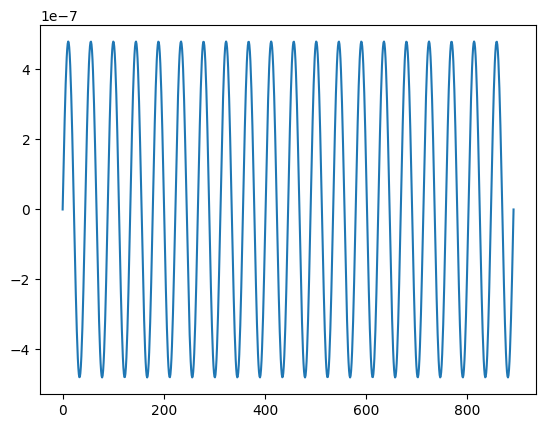

In [16]:
if myid == 0:
    print('air cuts made, line 310')

#define sine-exponential wave excitation

timeVec=np.linspace(0,runtime,Tsteps)

#MPI EJW Section #3 changes
#radius
r=3
inputx=2
inputy=int(gw1/2)
inputz=int(gh1/2)

# get loc by formula

inputid=int(inputx / npx)
inputlocx=int(inputx - inputid*npx+1)

if (myid == 0) :
    print("line 369: glb inputx, local inputx id, local inputx:  ",inputx,inputid,inputlocx)


szzConst=2*ts/(gs*rho1)

amp=10000
decayRate= 0
sinConst=ts*amp/rho1

sinInputSignal=sinConst*np.sin(2*np.pi*frequency*timeVec)*np.exp(-decayRate*timeVec)
#sinInputSignal-=0.0000001
#sinInputSignal[int(1/12*Tsteps):]=0

fig = plt.figure()
plt.plot(sinInputSignal)
plt.show()

In [17]:
# MPI EJW Section #4 changes 

#initialize fields
vx=np.zeros((npx,gw1,gh1))
vy=np.zeros((npx,gw1,gh1))
vz=np.zeros((npx,gw1,gh1))

sxx=np.zeros((npx,gw1,gh1))
syy=np.zeros((npx,gw1,gh1))
szz=np.zeros((npx,gw1,gh1))
sxy=np.zeros((npx,gw1,gh1))
sxz=np.zeros((npx,gw1,gh1))
syz=np.zeros((npx,gw1,gh1))

#record the signal at a specified location
### ADD map function for this
signalLocx=int(gl1/2)
signalLocy=int(gw1/2)
signalLocz=int(gh1/2)

vxSignal=np.zeros(Tsteps)
vySignal=np.zeros(Tsteps)
vzSignal=np.zeros(Tsteps)

In [24]:

#record the signal at a specified location
### ADD map function for this
#SAME AS INPUTZ?

#manually setting x for long where wave may not propaagate full lengthh in time

## All signals at 4 nodes from end
FromEnd = 50
# Top of rail
FSignalLocX= gl1-FromEnd
FSignalLocY=int(gw1/2)
FSignalLocZ=gh1-4

## End halfway up head
BSignalLocX=gl1-FromEnd
BSignalLocY=int(gw1/2)
BSignalLocZ=int((gh1-gridStartHead)/2+gridStartHead)

## left of head
USignalLocX=gl1-FromEnd
USignalLocY=gridStartHeadWidth+1
USignalLocZ=int((gh1-gridStartHead)/2+gridStartHead)

## right of head
DSignalLocX=gl1-FromEnd
DSignalLocY=gridEndHeadWidth-1
DSignalLocZ=int((gh1-gridStartHead)/2+gridStartHead)

## right of web
RSignalLocX=gl1-FromEnd
RSignalLocY=gridStartWeb+1
RSignalLocZ=int((gridStartHead-gridEndFoot)/2+gridEndFoot)

## Left of Web
LSignalLocX=gl1-FromEnd
LSignalLocY=gridEndWeb-1
LSignalLocZ=int((gridStartHead-gridEndFoot)/2+gridEndFoot)

## End of Web
MSignalLocX=gl1-FromEnd
MSignalLocY=int(gw1/2)
MSignalLocZ=int((gridStartHead-gridEndFoot)/2+gridEndFoot)


#signal locations going to be a quarter of the way in the middle from the 
# Front, Back, Up side, Down side, Right, Left, and Middle Middle Middle
FSignal=np.zeros((Tsteps,3))
BSignal=np.zeros((Tsteps,3))
USignal=np.zeros((Tsteps,3))
DSignal=np.zeros((Tsteps,3))
RSignal=np.zeros((Tsteps,3))
LSignal=np.zeros((Tsteps,3))
MSignal=np.zeros((Tsteps,3))

In [21]:
signalloc = np.zeros((npx,gw1,gh1))
signalloc=signalLocation[:,:,:]

stime = time.time()

In [22]:
# asdfasdf
MidMatrixX = np.zeros((gl1,Tsteps))
MidMatrixY = np.zeros((gl1,Tsteps))
MidMatrixZ = np.zeros((gl1,Tsteps))

Movements = np.zeros((gl1,gw1,gh1,Tsteps))
DisX = np.zeros((gl1,gw1,gh1))
DisY = np.zeros((gl1,gw1,gh1))
DisZ = np.zeros((gl1,gw1,gh1))


In [25]:
for t in range(Tsteps):
     
    if FFunction == 2:
        vz += signalloc * sinInputSignal[t]
        #print(np.sum(vz))
    
    if FFunction ==3:
        vx += signalloc * sinInputSignal[t]

    if FFunction == 4:
        vz += signalloc * sinInputSignal[t]

    for x in range(0,xmax):
        for y in range(0,ymax):
            for z in range(0,zmax):
                JBSU(x,y,z)

    
    # cut boundaries off of arrays
    '''Remove for Jupyter single processor
    sxxt=sxx[1:npx+1,:,:]
    syyt=syy[1:npx+1,:,:]
    szzt=szz[1:npx+1,:,:]
    sxyt=sxy[1:npx+1,:,:]
    sxzt=sxz[1:npx+1,:,:]
    syzt=syz[1:npx+1,:,:]

    # redistrubute ghost/boundary values
    sxx=distBox(sxxt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    syy=distBox(syyt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    szz=distBox(szzt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    sxy=distBox(sxyt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    sxz=distBox(sxzt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    syz=distBox(syzt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    '''
    
    #if the forcing function is a stress
    if FFunction == 1:
        szz -= signalloc * specificWheelLoad

    for x in range(0,xmax):
        for y in range(0,ymax):
            for z in range(0,zmax):
                JBUV(x,y,z)

    MidMatrixX[:,t] = vx[:,MSignalLocY,MSignalLocZ]
    MidMatrixY[:,t] = vy[:,MSignalLocY,MSignalLocZ]
    MidMatrixZ[:,t] = vz[:,MSignalLocY,MSignalLocZ]
    
    vxg=vx #[1:npx+1,:,:]        
    vyg=vy#[1:npx+1,:,:]        
    vzg=vz#[1:npx+1,:,:]        

    
    if (myid == 0 ) :
        USignal[t]=[vxg[USignalLocX,USignalLocY,USignalLocZ],vyg[USignalLocX,USignalLocY,USignalLocZ],vzg[USignalLocX,USignalLocY,USignalLocZ]]
        DSignal[t]=[vxg[DSignalLocX,DSignalLocY,DSignalLocZ],vyg[DSignalLocX,DSignalLocY,DSignalLocZ],vzg[DSignalLocX,DSignalLocY,DSignalLocZ]]
        RSignal[t]=[vxg[RSignalLocX,RSignalLocY,RSignalLocZ],vyg[RSignalLocX,RSignalLocY,RSignalLocZ],vzg[RSignalLocX,RSignalLocY,RSignalLocZ]]
        LSignal[t]=[vxg[LSignalLocX,LSignalLocY,LSignalLocZ],vyg[LSignalLocX,LSignalLocY,LSignalLocZ],vzg[LSignalLocX,LSignalLocY,LSignalLocZ]]
        MSignal[t]=[vxg[MSignalLocX,MSignalLocY,MSignalLocZ],vyg[MSignalLocX,MSignalLocY,MSignalLocZ],vzg[MSignalLocX,MSignalLocY,MSignalLocZ]]
        FSignal[t]=[vxg[FSignalLocX,FSignalLocY,FSignalLocZ],vyg[FSignalLocX,FSignalLocY,FSignalLocZ],vzg[FSignalLocX,FSignalLocY,FSignalLocZ]]
        BSignal[t]=[vxg[BSignalLocX,BSignalLocY,BSignalLocZ],vyg[BSignalLocX,BSignalLocY,BSignalLocZ],vzg[BSignalLocX,BSignalLocY,BSignalLocZ]]
        
        DisX += vx[:,:,:] * ts
        DisY += vy[:,:,:] * ts
        DisZ += vz[:,:,:] * ts
        Movements[:,:,:,t] = np.sqrt(DisX**2 + DisY**2 + DisZ**2)
        
        if t%5==0:
        
            fig=plt.figure()
            plt.contourf(np.transpose(vxg[:,:,int(gh1/2)]), cmap='seismic')
            plt.savefig(imFolder+'Mid/vyMidHeightShear'+str(t).zfill(5)+'.png')
            # SideRub vs TopHit for which case
            plt.close(fig)
            '''
            fig=plt.figure()
            plt.contourf(np.transpose(vxg[:,int(gw1/2),:]), cmap='seismic')
            plt.savefig(imFolder + 'Vert/vyVertShear'+str(t).zfill(5)+'.png')
            # SideRub vs TopHit for which case
            plt.close(fig)    
            
            fig=plt.figure()
            plt.contourf(np.transpose(vxg[int(gl1/2),:,:]), cmap='seismic')
            plt.savefig(imFolder + 'Head/vyMidLenShear'+str(t).zfill(5)+'.png')
            # SideRub vs TopHit for which case
            plt.close(fig)  
    
            fig=plt.figure()
            plt.contourf(np.transpose(vxg[:,:,int(gh1/4)]), cmap='seismic')
            plt.savefig(imFolder+'zplane25/vy25Shear'+str(t).zfill(5)+'.png')
            # SideRub vs TopHit for which case
            plt.close(fig)
            
            fig=plt.figure()
            plt.contourf(np.transpose(vxg[:,:,int(3*gh1/4)]), cmap='seismic')
            plt.savefig(imFolder+'zplane75/vy75Shear'+str(t).zfill(5)+'.png')
            # SideRub vs TopHit for which case
            plt.close(fig)
            
            fig=plt.figure()
            plt.contourf(np.transpose(Movements[:,:,zmax-1,t]), cmap='seismic')
            plt.savefig(imFolder+'TopSurface/TopSurface'+str(t).zfill(5)+'.png')
            # SideRub vs TopHit for which case
            plt.close(fig)
            
            fig=plt.figure()
            plt.contourf(np.transpose(Movements[3:,ymax,:,t]), cmap='seismic')
            plt.savefig(imFolder+'RightSurface/RightSurface'+str(t).zfill(5)+'.png')
            # SideRub vs TopHit for which case
            plt.close(fig)
            
            fig=plt.figure()
            plt.contourf(np.transpose(Movements[3:,0,:,t]), cmap='seismic')
            plt.savefig(imFolder+'LeftSurface/LeftSurface'+str(t).zfill(5)+'.png')
            # SideRub vs TopHit for which case
            plt.close(fig)
            '''

    # Collect vx, sxx checksum contributions for printing
    vxt=vx[1:npx+1,:,:]
    sxxt=sxx[1:npx+1,:,:]

    #ckvs=np.array(0.0,'d')
    #ckss=np.array(0.0,'d')
    
    ckv=np.sum(np.absolute(vxg))
    cks=np.sum(np.absolute(sxx))
    #mpi_comm.Reduce(ckv,ckvs,op=MPI.SUM,root=0)
    #mpi_comm.Reduce(cks,ckss,op=MPI.SUM,root=0)

    if (myid == 0 ):
        print(t,'/',Tsteps-1,'check vx, sxx:',ckv,cks, int(((time.time()-stime)/60.0)*100)/100)
    sys.stdout.flush()

0 / 891 check vx, sxx: 0.0 0.0 1.19
1 / 891 check vx, sxx: 5.8354036935765795e-08 6.690197711267969 1.39
2 / 891 check vx, sxx: 2.73125994554622e-07 23.367080828605456 1.59
3 / 891 check vx, sxx: 7.638946294029558e-07 49.851780539754365 1.78
4 / 891 check vx, sxx: 1.6735837179516323e-06 85.99563066095439 1.98
5 / 891 check vx, sxx: 3.17048815768231e-06 136.20824427655293 2.18
6 / 891 check vx, sxx: 5.442974337837004e-06 211.86393997823026 2.37
7 / 891 check vx, sxx: 8.711010399208882e-06 315.00357019766045 2.57
8 / 891 check vx, sxx: 1.3151467722197251e-05 455.8092769329753 2.76
9 / 891 check vx, sxx: 1.8909517519802465e-05 646.8013126500454 2.96
10 / 891 check vx, sxx: 2.6100148673137035e-05 895.895504604298 3.16
11 / 891 check vx, sxx: 3.4820169819699314e-05 1206.5446125377011 3.35
12 / 891 check vx, sxx: 4.507622639766324e-05 1580.9081532809041 3.55
13 / 891 check vx, sxx: 5.685624070441757e-05 2022.4481005604487 3.74
14 / 891 check vx, sxx: 7.00759114179609e-05 2540.4731967835846 3

118 / 891 check vx, sxx: 0.003027938306531621 100106.97091769283 24.48
119 / 891 check vx, sxx: 0.0030654455247187125 101654.22368845074 24.68
120 / 891 check vx, sxx: 0.003097203945396582 103316.33799656086 24.88
121 / 891 check vx, sxx: 0.003121463023983108 105030.5095919198 25.08
122 / 891 check vx, sxx: 0.0031401381160071186 106627.48345878925 25.28
123 / 891 check vx, sxx: 0.003155743413320629 108071.12101291445 25.47
124 / 891 check vx, sxx: 0.0031649340995340163 109389.44746231008 25.67
125 / 891 check vx, sxx: 0.0031698299715846633 110543.85866455422 25.87
126 / 891 check vx, sxx: 0.0031728289945462586 111487.08737629889 26.06
127 / 891 check vx, sxx: 0.0031754775819735643 112239.91133706915 26.26
128 / 891 check vx, sxx: 0.0031832581025487555 112889.55305041389 26.45
129 / 891 check vx, sxx: 0.003203582362096961 113380.71033885227 26.65
130 / 891 check vx, sxx: 0.0032361841034385095 113894.519515927 26.85
131 / 891 check vx, sxx: 0.0032794061572947587 114558.21720656802 27.04


234 / 891 check vx, sxx: 0.007392463151305279 214433.16821864815 47.29
235 / 891 check vx, sxx: 0.007436102702857848 213380.78105891714 47.49
236 / 891 check vx, sxx: 0.007466152445223129 212918.21737147283 47.68
237 / 891 check vx, sxx: 0.007479101570370264 213420.71841734994 47.88
238 / 891 check vx, sxx: 0.007476283471180158 214966.0588039385 48.07
239 / 891 check vx, sxx: 0.007464400269145971 217446.33013376975 48.27
240 / 891 check vx, sxx: 0.00744777255682934 220641.3880229135 48.46
241 / 891 check vx, sxx: 0.0074339040898182525 224390.2129375432 48.66
242 / 891 check vx, sxx: 0.007424737069067341 228477.94685943247 48.86
243 / 891 check vx, sxx: 0.007421906467435479 232649.4120662443 49.05
244 / 891 check vx, sxx: 0.007421596025950435 236522.47285768823 49.25
245 / 891 check vx, sxx: 0.007428409277170155 239976.40325700608 49.44
246 / 891 check vx, sxx: 0.007444281156386201 243033.14649238356 49.64
247 / 891 check vx, sxx: 0.007466721926038635 245407.04239136993 49.83
248 / 891 

351 / 891 check vx, sxx: 0.011308107128550514 356949.5865315804 70.19
352 / 891 check vx, sxx: 0.011296834168760882 360025.84448683565 70.39
353 / 891 check vx, sxx: 0.011291325629190257 363345.9369415551 70.58
354 / 891 check vx, sxx: 0.011292666933124923 366693.129563267 70.78
355 / 891 check vx, sxx: 0.011306765328397759 369838.22958878323 70.98
356 / 891 check vx, sxx: 0.011349316073324471 372761.9948287164 71.18
357 / 891 check vx, sxx: 0.011426832745216936 375124.9695252576 71.37
358 / 891 check vx, sxx: 0.011517321242564922 377053.6998021457 71.57
359 / 891 check vx, sxx: 0.011609299765759497 378431.43384044606 71.76
360 / 891 check vx, sxx: 0.011698480241554966 379273.9154876425 71.95
361 / 891 check vx, sxx: 0.011792024357370014 379594.88299815246 72.15
362 / 891 check vx, sxx: 0.011894767599987435 379447.7984835272 72.34
363 / 891 check vx, sxx: 0.011989651611707858 379149.9034138335 72.54
364 / 891 check vx, sxx: 0.012076356469829354 378641.6174703924 72.73
365 / 891 check v

468 / 891 check vx, sxx: 0.01565083504957435 516256.74400787934 93.06
469 / 891 check vx, sxx: 0.015724524373909112 518483.5328069105 93.26
470 / 891 check vx, sxx: 0.01580461228518991 520456.68837443617 93.46
471 / 891 check vx, sxx: 0.015879589250965973 521714.1510587167 93.65
472 / 891 check vx, sxx: 0.01594506651264924 522504.00194568693 93.84
473 / 891 check vx, sxx: 0.01600247800526799 522934.7011601728 94.04
474 / 891 check vx, sxx: 0.016065981980086755 522992.7047038801 94.23
475 / 891 check vx, sxx: 0.01612105671924862 522780.22342186223 94.43
476 / 891 check vx, sxx: 0.016164247669130136 522722.76115861133 94.62
477 / 891 check vx, sxx: 0.016203168194075943 522490.564365416 94.81
478 / 891 check vx, sxx: 0.016235869431720017 522294.30456770543 95.01
479 / 891 check vx, sxx: 0.016257269745460497 522172.002375991 95.2
480 / 891 check vx, sxx: 0.016264965084189967 522399.78744203766 95.4
481 / 891 check vx, sxx: 0.01625920748367724 522630.77633368626 95.59
482 / 891 check vx, sx

594 / 891 check vx, sxx: 0.019928469961985315 660090.3078990207 117.67
595 / 891 check vx, sxx: 0.01990924911656807 661655.1219398994 117.87
596 / 891 check vx, sxx: 0.019902937226891633 663901.1325251521 118.07
597 / 891 check vx, sxx: 0.01990850535430704 666552.9962507688 118.26
598 / 891 check vx, sxx: 0.019932070053952724 669723.25754606 118.46
599 / 891 check vx, sxx: 0.019975960979246858 673188.1653727478 118.65
600 / 891 check vx, sxx: 0.020034520334214666 677266.4541575097 118.85
601 / 891 check vx, sxx: 0.020110147049334292 681055.7726132587 119.04
602 / 891 check vx, sxx: 0.020194373318711833 684697.8397301811 119.23
603 / 891 check vx, sxx: 0.020281810076011927 687947.5235020062 119.43
604 / 891 check vx, sxx: 0.02036928292297974 690451.1404495455 119.62
605 / 891 check vx, sxx: 0.02045754610164901 692241.3177968779 119.82
606 / 891 check vx, sxx: 0.020544432062713752 693302.7665705989 120.01
607 / 891 check vx, sxx: 0.02062871475457811 693933.1539204607 120.21
608 / 891 che

711 / 891 check vx, sxx: 0.024206682558692502 818485.5753209043 140.46
712 / 891 check vx, sxx: 0.02427159523274931 821910.5602164407 140.66
713 / 891 check vx, sxx: 0.024358262397425647 825105.690927862 140.86
714 / 891 check vx, sxx: 0.024449110618834022 827889.4100176588 141.05
715 / 891 check vx, sxx: 0.02455295430059179 830068.5813431465 141.25
716 / 891 check vx, sxx: 0.02464524901293898 831660.8337518844 141.44
717 / 891 check vx, sxx: 0.0247371177601675 832595.2432592254 141.64
718 / 891 check vx, sxx: 0.024816856884805057 833155.0836266836 141.83
719 / 891 check vx, sxx: 0.024877238427009434 833131.7171761214 142.03
720 / 891 check vx, sxx: 0.024915846903500315 832880.0424764891 142.22
721 / 891 check vx, sxx: 0.02493417228596638 832363.5417263996 142.42
722 / 891 check vx, sxx: 0.024937389968175742 831502.3891152409 142.61
723 / 891 check vx, sxx: 0.024928416835479975 830745.6488525455 142.81
724 / 891 check vx, sxx: 0.024904326743772603 829915.3849328642 143.0
725 / 891 chec

828 / 891 check vx, sxx: 0.028936148916148784 977439.8856594604 163.28
829 / 891 check vx, sxx: 0.0290050362934542 977218.7173005531 163.47
830 / 891 check vx, sxx: 0.02905765074844019 976577.0354074736 163.67
831 / 891 check vx, sxx: 0.029083468764005423 976075.7496137349 163.86
832 / 891 check vx, sxx: 0.029088693528200003 975266.7280012099 164.06
833 / 891 check vx, sxx: 0.029071471273594295 974219.7366734763 164.26
834 / 891 check vx, sxx: 0.02904533036519461 973521.0711241725 164.45
835 / 891 check vx, sxx: 0.029004963010108704 973046.017653571 164.65
836 / 891 check vx, sxx: 0.02895703787685219 972678.9985558002 164.84
837 / 891 check vx, sxx: 0.02891089809245594 972655.3796033448 165.04
838 / 891 check vx, sxx: 0.028869872035202377 973456.7163076631 165.23
839 / 891 check vx, sxx: 0.02884367280488429 974848.0561241831 165.42
840 / 891 check vx, sxx: 0.02883083147673507 977007.6070171666 165.62
841 / 891 check vx, sxx: 0.028842276114063977 979341.8606509067 165.81
842 / 891 check

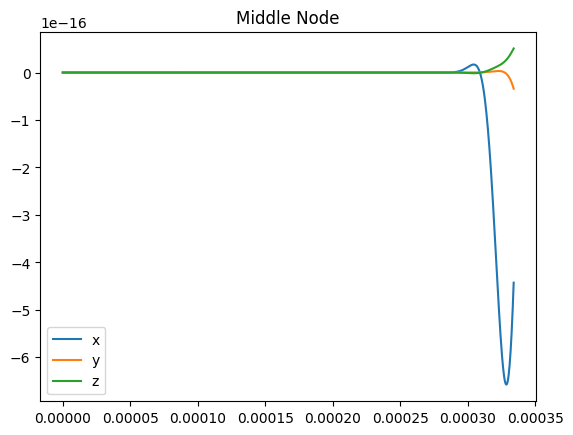

In [27]:
vxDisplacement = [0]
vyDisplacement = [0]
vzDisplacement = [0]

Times = np.linspace(0, len(MSignal), num=len(MSignal)+1)
Times *= ts

for i in range(len(MSignal)):
    vxDisplacement.append(vxDisplacement[i-1]+MSignal[i][0] * ts)
    vyDisplacement.append(vyDisplacement[i-1]+MSignal[i][1] * ts)
    vzDisplacement.append(vzDisplacement[i-1]+MSignal[i][2] * ts)

plt.clf()
plt.title('Middle Node')
plt.plot(Times,vxDisplacement,label='x')
plt.plot(Times,vyDisplacement,label='y')
plt.plot(Times,vzDisplacement,label='z')
plt.legend()
plt.savefig(imFolder+runName+'DisplaceMid.png')
#plt.show()

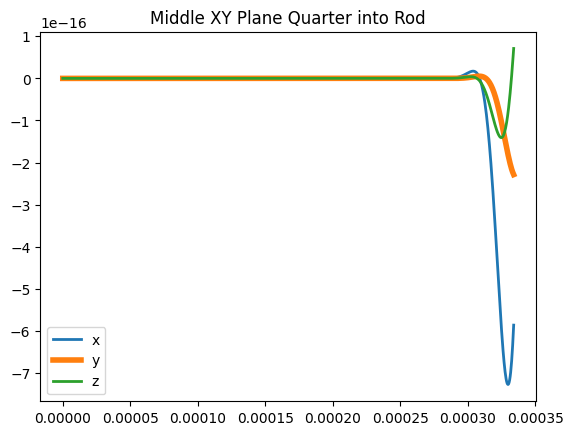

In [28]:
vxDisplacement = [0]
vyDisplacement = [0]
vzDisplacement = [0]

for i in range(len(FSignal)):
    vxDisplacement.append(vxDisplacement[i-1]+FSignal[i][0] * ts)
    vyDisplacement.append(vyDisplacement[i-1]+FSignal[i][1] * ts)
    vzDisplacement.append(vzDisplacement[i-1]+FSignal[i][2] * ts)

plt.clf()
plt.title('Middle XY Plane Quarter into Rod')
plt.plot(Times,vxDisplacement,label='x', linewidth=2)
plt.plot(Times,vyDisplacement,label='y', linewidth=4)
plt.plot(Times,vzDisplacement,label='z', linewidth=2)
plt.legend()
plt.savefig(imFolder+runName+'DisplaceFront.png')
plt.show()

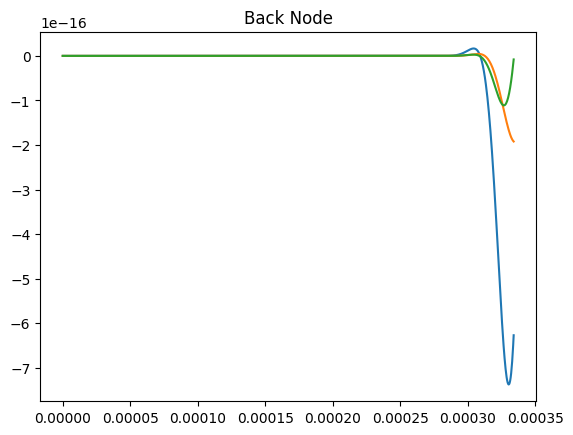

In [29]:
vxDisplacement = [0]
vyDisplacement = [0]
vzDisplacement = [0]

for i in range(len(BSignal)):
    vxDisplacement.append(vxDisplacement[i-1]+BSignal[i][0] * ts)
    vyDisplacement.append(vyDisplacement[i-1]+BSignal[i][1] * ts)
    vzDisplacement.append(vzDisplacement[i-1]+BSignal[i][2] * ts)

plt.clf()
plt.title('Back Node')
plt.plot(Times,vxDisplacement)
plt.plot(Times,vyDisplacement)
plt.plot(Times,vzDisplacement)
plt.savefig(imFolder+runName+'DisplaceBack.png')

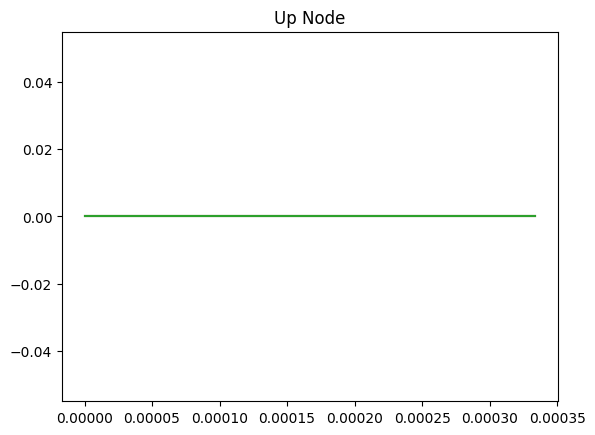

In [30]:
vxDisplacement = [0]
vyDisplacement = [0]
vzDisplacement = [0]

for i in range(len(USignal)):
    vxDisplacement.append(vxDisplacement[i-1]+USignal[i][0] * ts)
    vyDisplacement.append(vyDisplacement[i-1]+USignal[i][1] * ts)
    vzDisplacement.append(vzDisplacement[i-1]+USignal[i][2] * ts)

plt.clf()
plt.title('Up Node')
plt.plot(Times,vxDisplacement)
plt.plot(Times,vyDisplacement)
plt.plot(Times,vzDisplacement)
plt.savefig(imFolder+runName+'DisplaceUp.png')

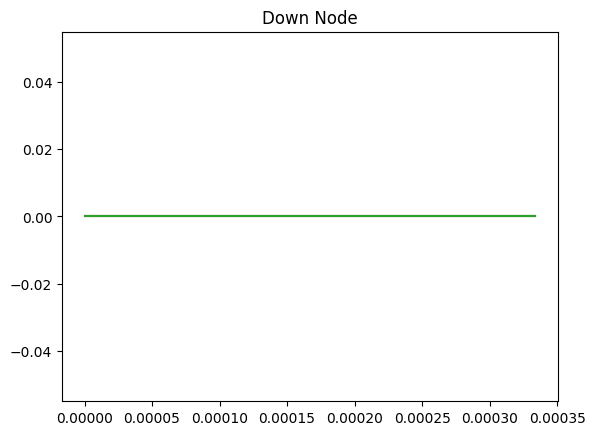

In [31]:
vxDisplacement = [0]
vyDisplacement = [0]
vzDisplacement = [0]

for i in range(len(DSignal)):
    vxDisplacement.append(vxDisplacement[i-1]+DSignal[i][0] * ts)
    vyDisplacement.append(vyDisplacement[i-1]+DSignal[i][1] * ts)
    vzDisplacement.append(vzDisplacement[i-1]+DSignal[i][2] * ts)

plt.clf()
plt.title('Down Node')
plt.plot(Times,vxDisplacement)
plt.plot(Times,vyDisplacement)
plt.plot(Times,vzDisplacement)
plt.savefig(imFolder+runName+'DisplaceDown.png')

In [32]:
MidDisplaceX = np.zeros(np.shape(MidMatrixX))
MidDisplaceY = np.zeros(np.shape(MidMatrixY))
MidDisplaceZ = np.zeros(np.shape(MidMatrixZ))


In [33]:
for i in range(np.shape(MidMatrixX)[0]):
    for j in range(np.shape(MidMatrixX)[1]):
        if j == 0:
            MidDisplaceX[i,j]=MidMatrixX[i,j]*ts
            MidDisplaceY[i,j]=MidMatrixY[i,j]*ts
            MidDisplaceZ[i,j]=MidMatrixZ[i,j]*ts
        else:
            MidDisplaceX[i,j]=MidDisplaceX[i,j-1]+MidMatrixX[i,j]*ts
            MidDisplaceY[i,j]=MidDisplaceY[i,j-1]+MidMatrixY[i,j]*ts
            MidDisplaceZ[i,j]=MidDisplaceZ[i,j-1]+MidMatrixZ[i,j]*ts
            

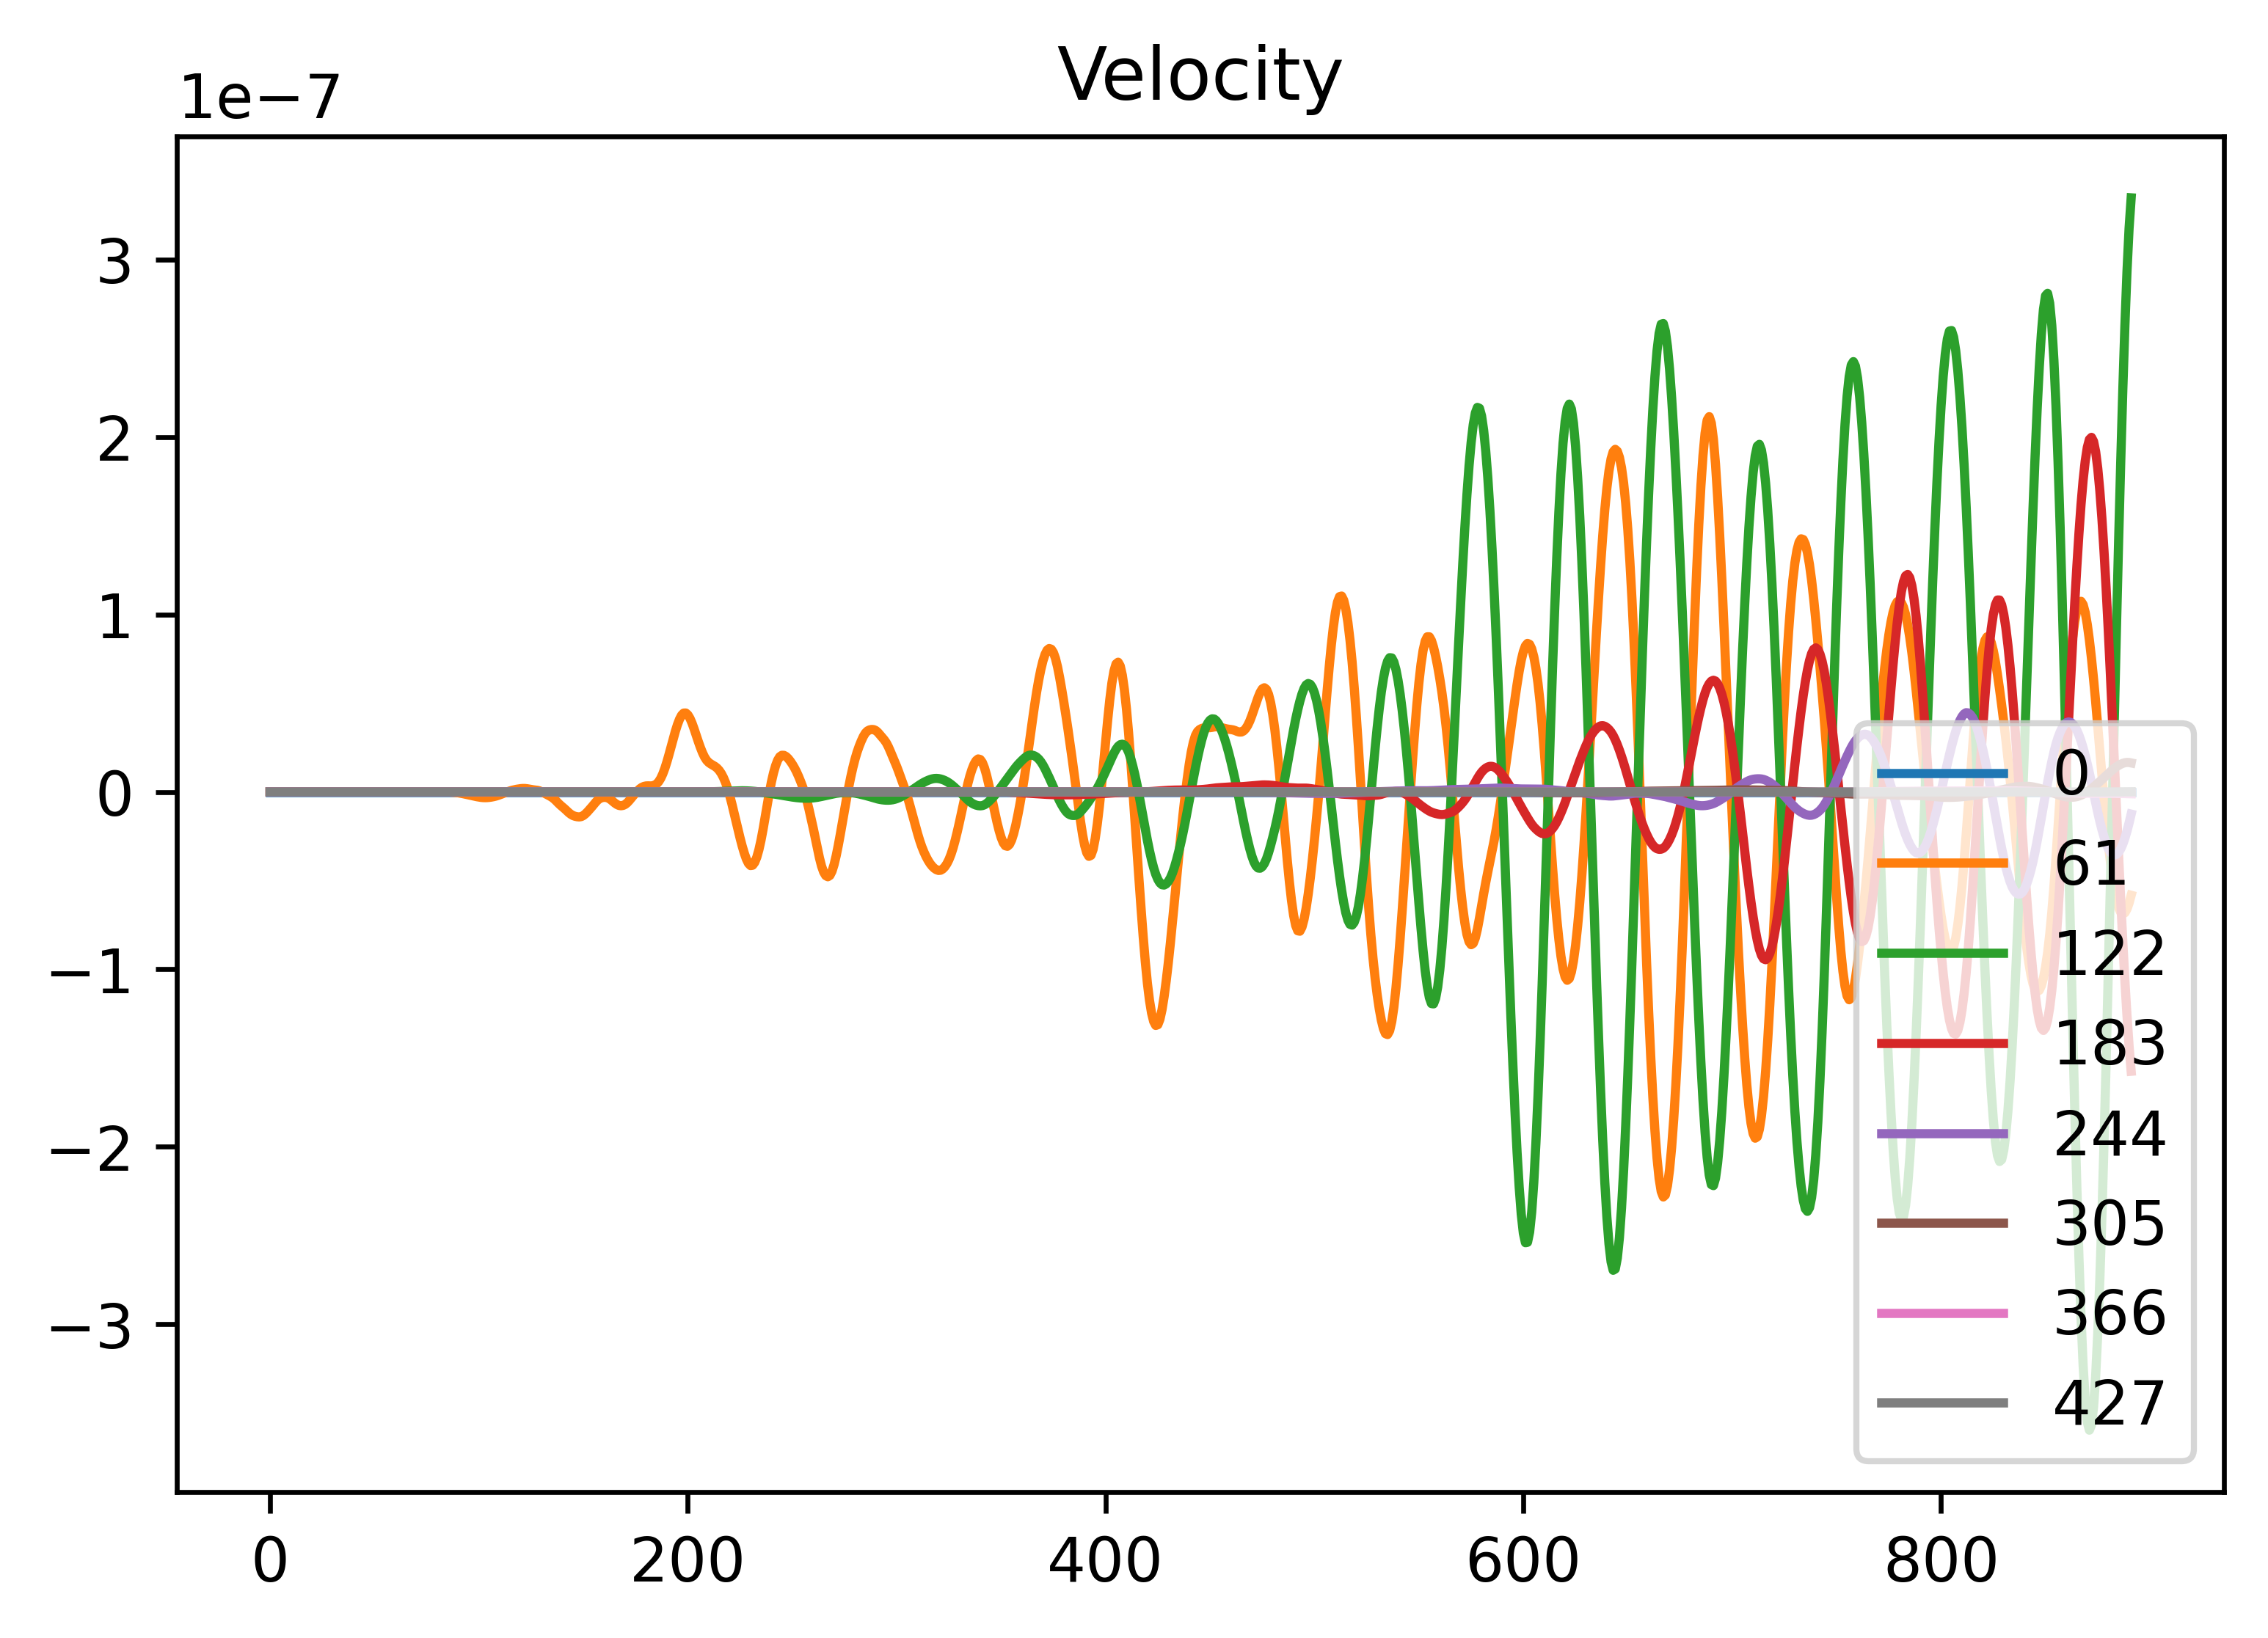

In [34]:
pts = 8
rng = int(gl1/pts)-1

fig = plt.figure(dpi=600, figsize=(6,4))
for i in range(pts):
    plt.plot(MidMatrixX[i*rng,:],label=str(i*rng))
plt.title('Velocity')
plt.legend()
plt.savefig(imFolder+runName+'MidVelocities.png')
plt.show()

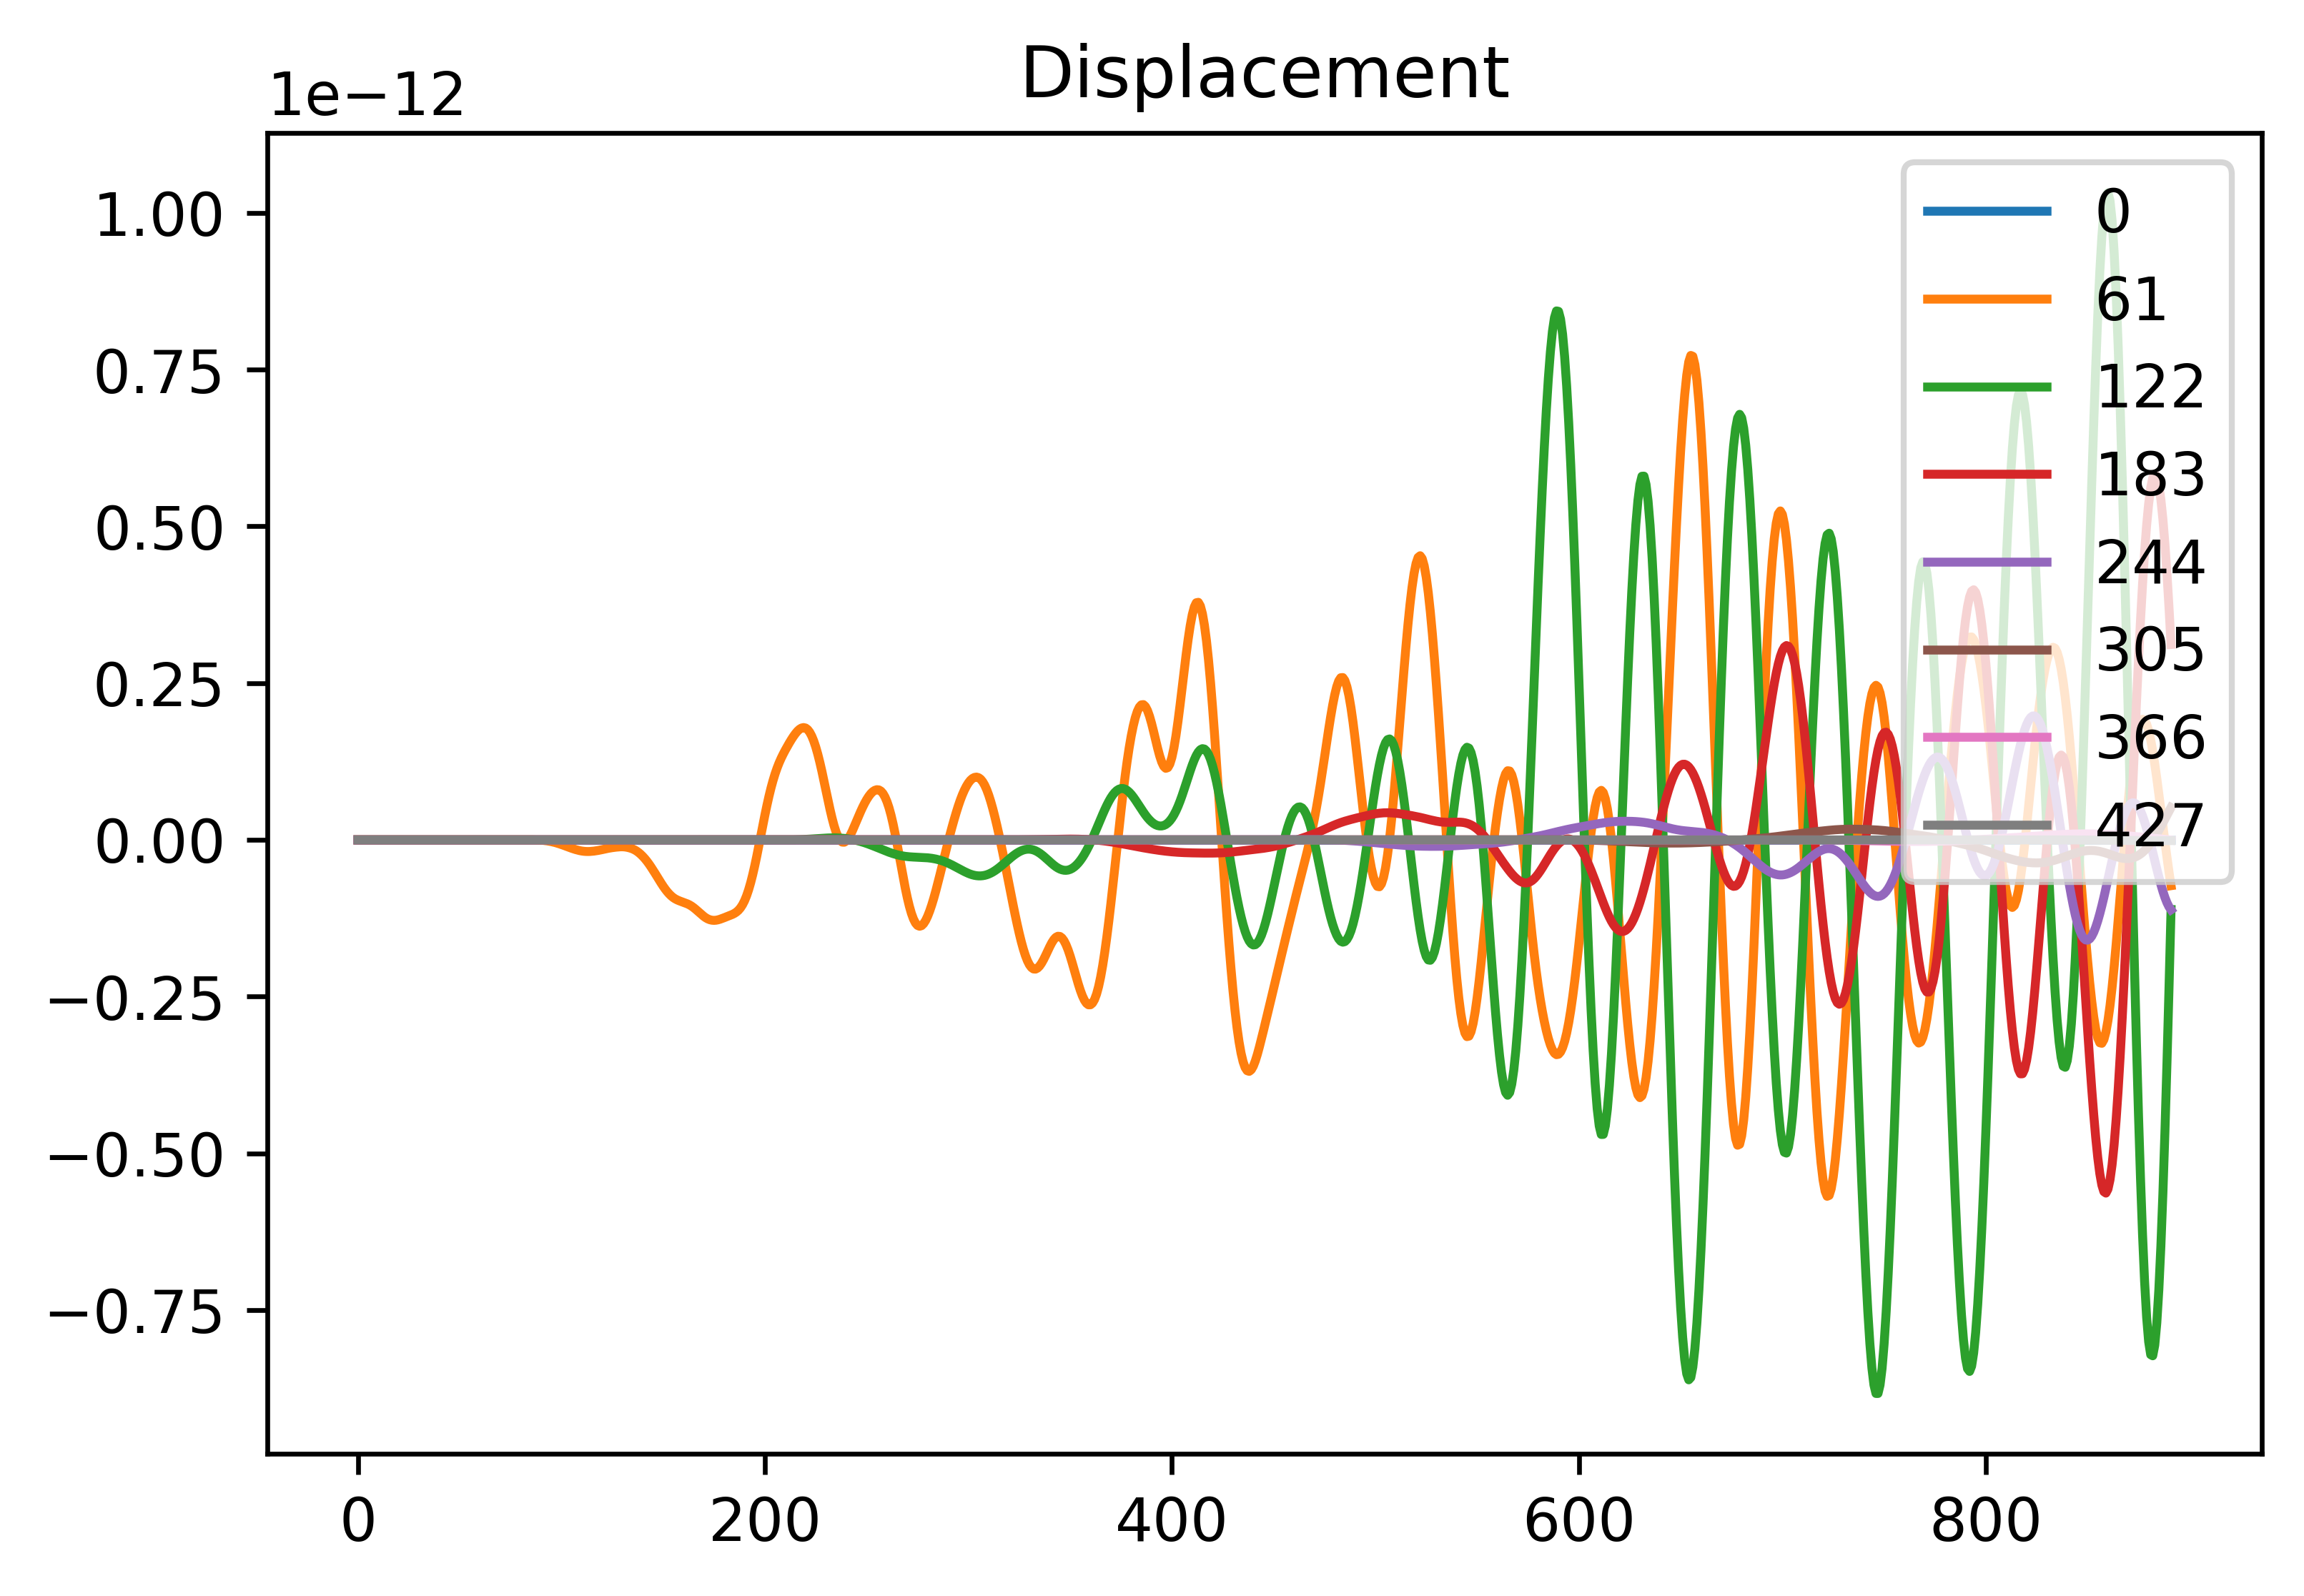

In [35]:
fig = plt.figure(dpi=600, figsize=(6,4))
for i in range(pts):
    plt.plot(MidDisplaceX[i*rng,:],label=str(i*rng))
plt.legend()
plt.title('Displacement')
plt.savefig(imFolder+runName+'MidDisplacementsX.png')
plt.show()

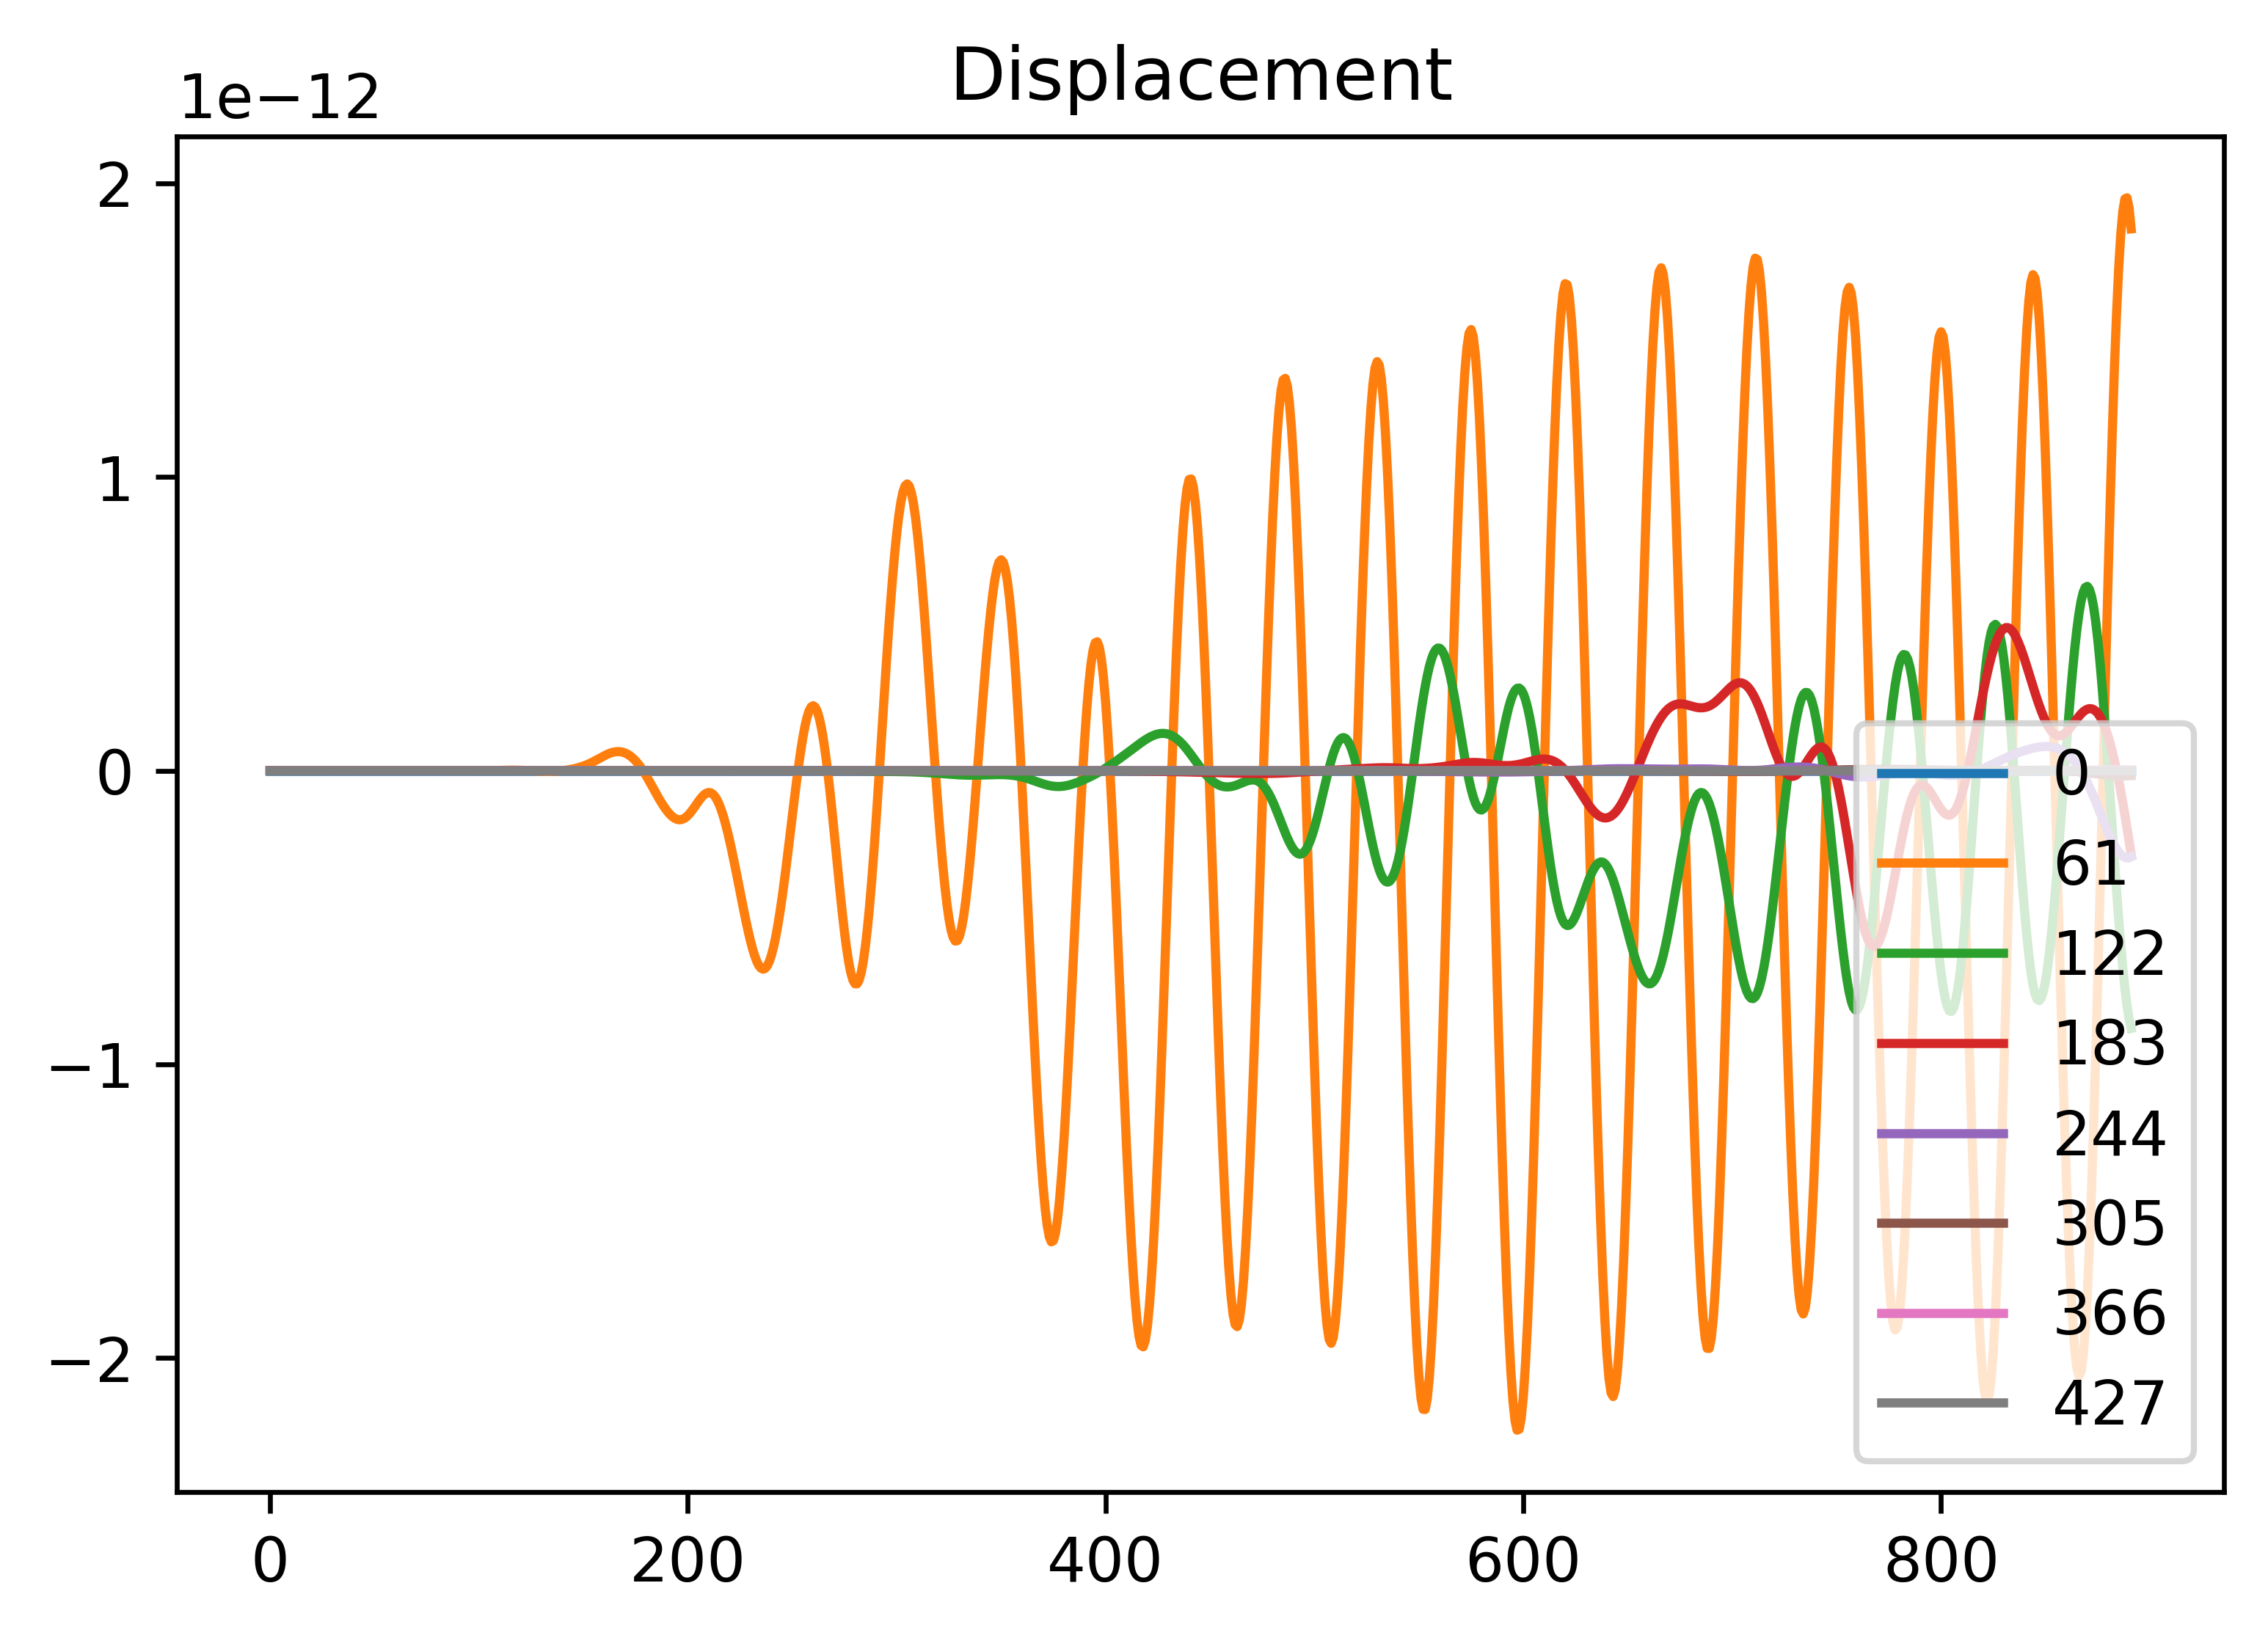

In [36]:
fig = plt.figure(dpi=600, figsize=(6,4))
for i in range(pts):
    plt.plot(MidDisplaceY[i*rng,:],label=str(i*rng))
plt.legend()
plt.title('Displacement')
plt.savefig(imFolder+runName+'MidDisplacementsY.png')
plt.show()

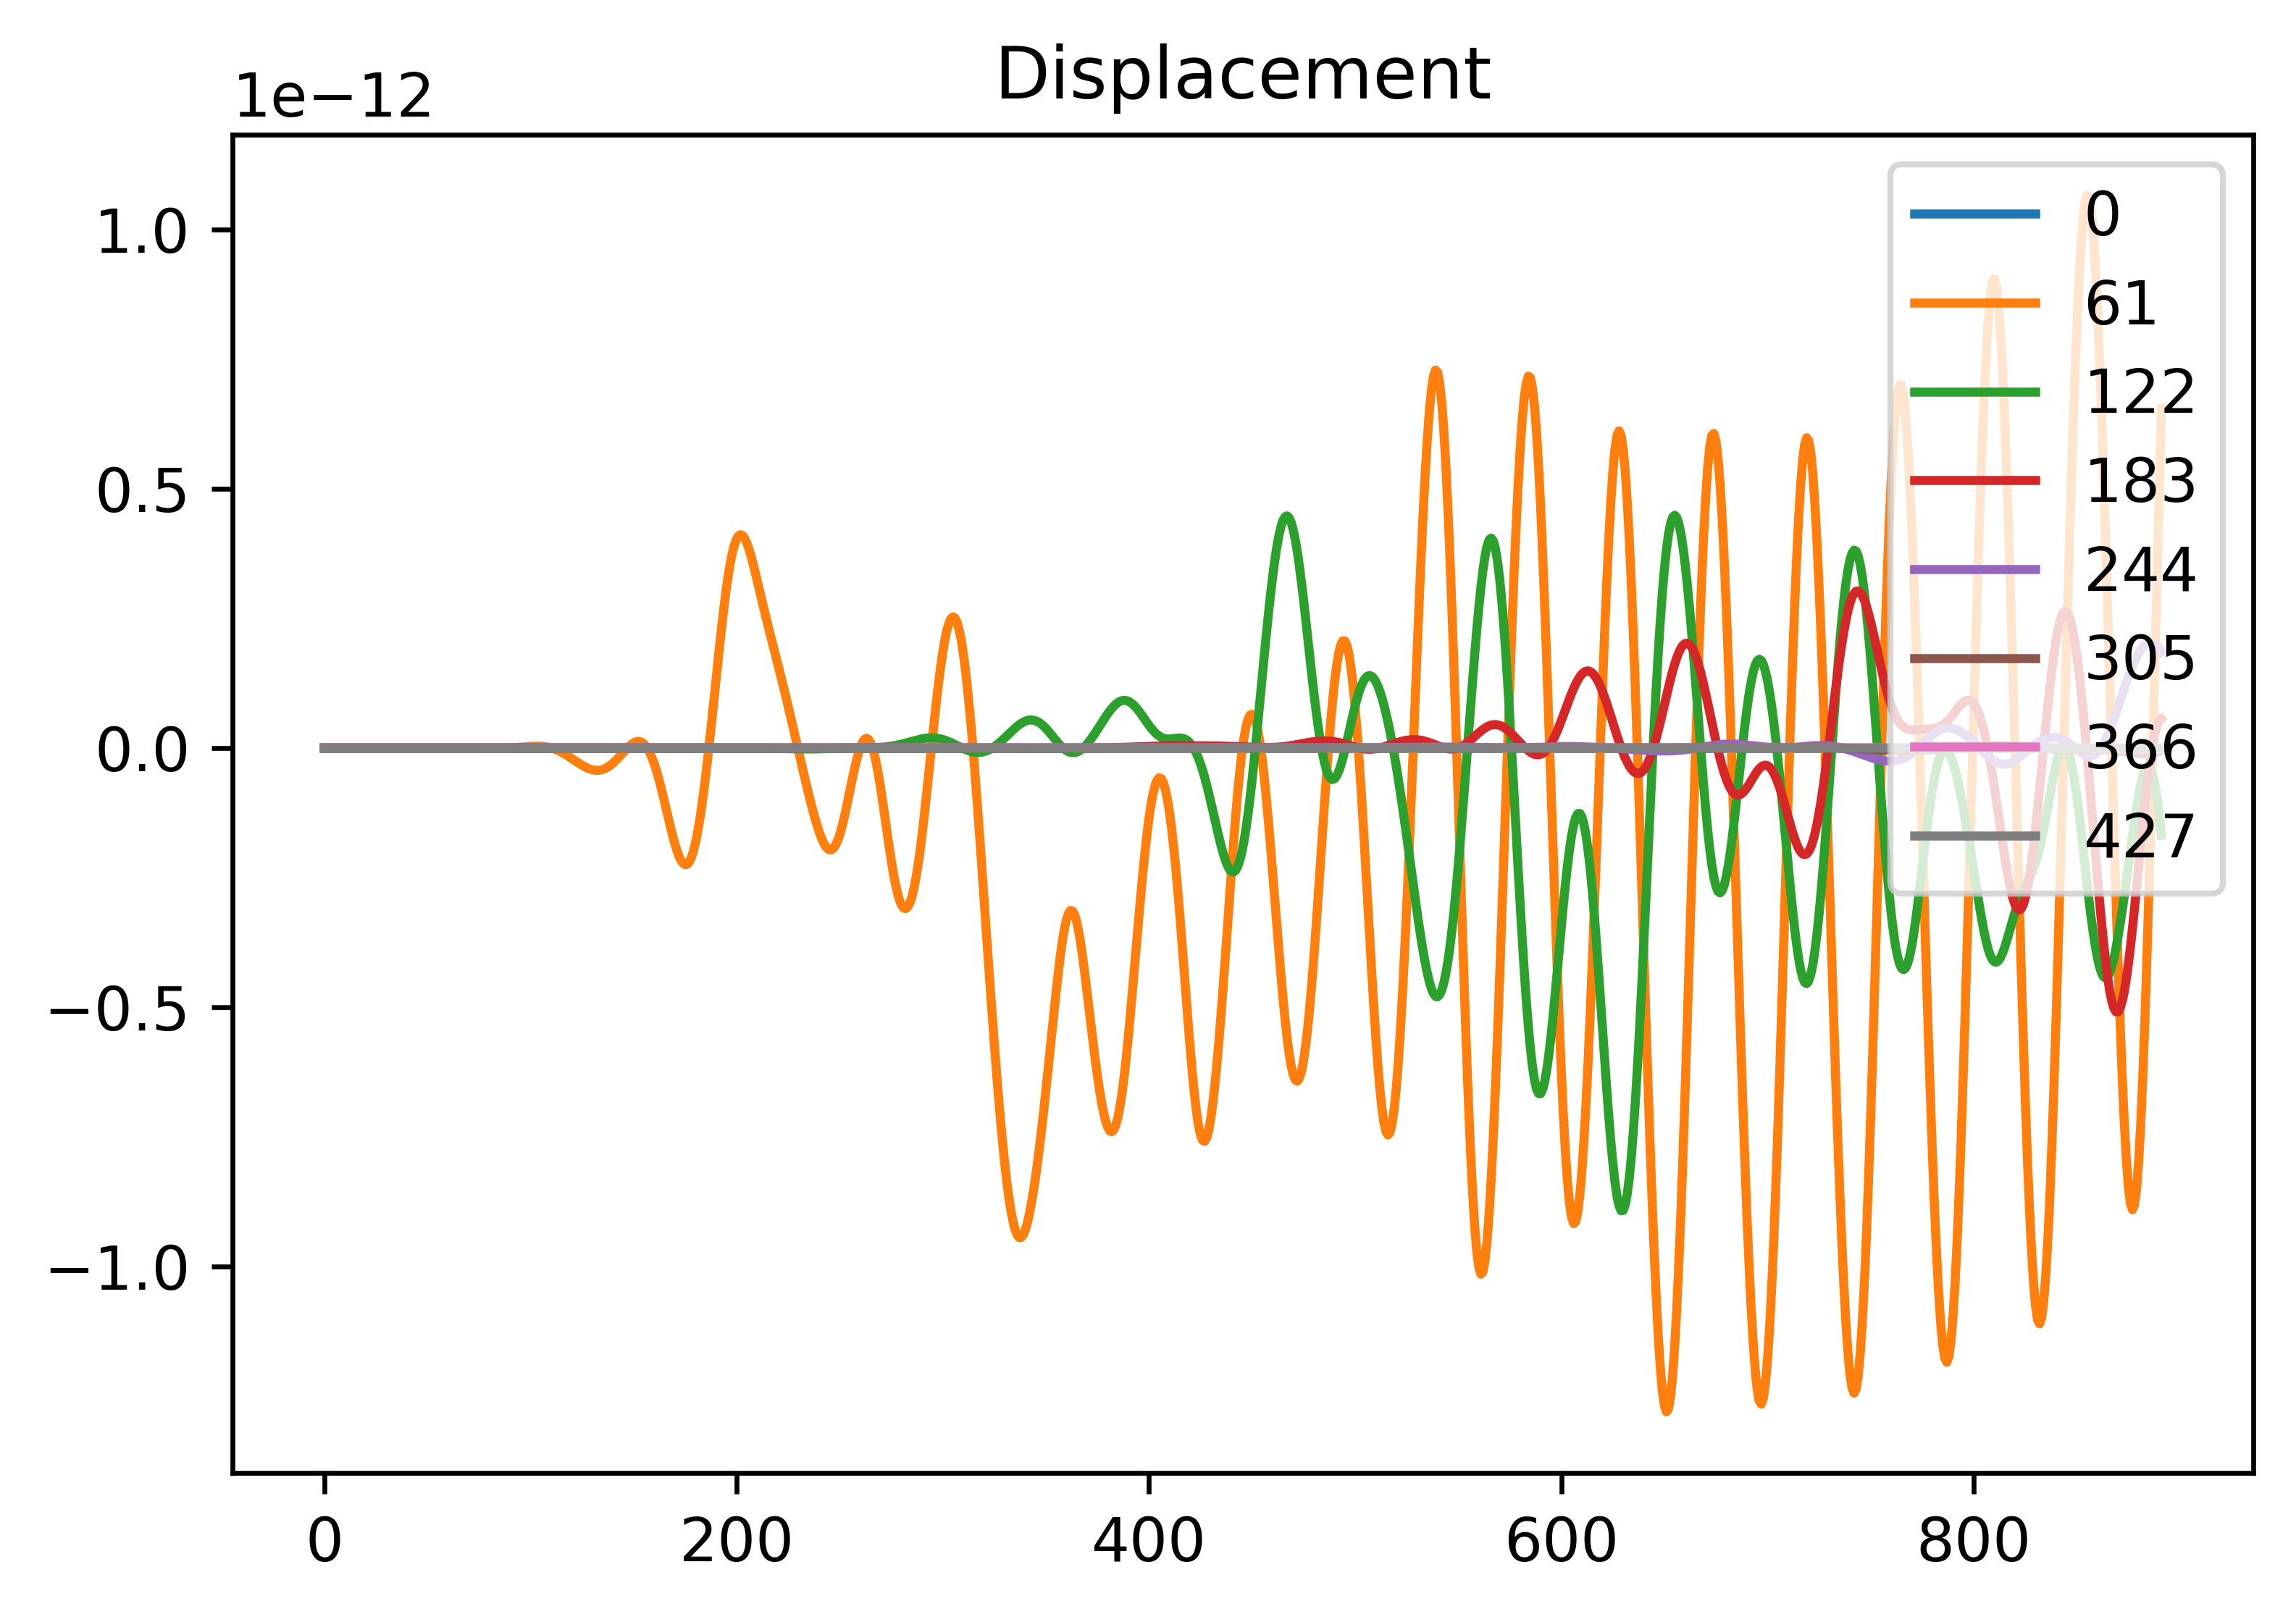

In [37]:
fig = plt.figure(dpi=600, figsize=(6,4))
for i in range(pts):
    plt.plot(MidDisplaceZ[i*rng,:],label=str(i*rng))
plt.legend()
plt.title('Displacement')
plt.savefig(imFolder+runName+'MidDisplacementsZ.png')
plt.show()

In [38]:
import multiprocessing
from joblib import Parallel, delayed
num_jobs=19

In [39]:
def EnergyFig(t, xStart, xEnd, yStart, yEnd, zStart, zEnd, Folder, v, figH):
    
    fig = plt.figure(figsize=(6,figH), dpi=300)
    
    Image = Movements[xStart:xEnd, yStart:yEnd, zStart:zEnd,t].T
    
    x,y,z = np.shape(Image)
    if x ==1:
        I2 = np.squeeze(Image, axis=(0,))
    if y ==1:
        I2 = np.squeeze(Image, axis=(1,))
    if z ==1:
        I2 = np.squeeze(Image, axis=(2,))
    
    plt.contourf(I2, v, cmap=plt.cm.jet)
    plt.savefig(imFolder+Folder+'/Energy'+str(t).zfill(5)+'.png')
    plt.close(fig)

In [40]:
def AnimationBook(xStart, xEnd, yStart, yEnd, zStart, zEnd, Folder):

    if xStart - xEnd == 0.0:
        figH = 6 * (yEnd - yStart) / (zEnd-zStart)
        xEnd+=1
    elif yStart - yEnd == 0.0:
        figH = 6 * (zEnd - zStart) / (xEnd-xStart)
        yEnd+=1
    elif zStart - zEnd == 0.0:
        figH = 6 * (yEnd - yStart) / (xEnd-xStart)
        zEnd+=1
    else:
        figH = 0

    if figH==0:
        print("Error, no Dimmension is a plane",yStart-yEnd)
    else:
        EMin = np.min(Movements[xStart:xEnd, yStart:yEnd, zStart:zEnd,:])
        EMax = np.max(Movements[xStart:xEnd, yStart:yEnd, zStart:zEnd,:])
        v = np.linspace(EMin, EMax, 30, endpoint=True)[0:20]

        temp = Parallel(n_jobs=num_jobs)(delayed(EnergyFig)(t, xStart, xEnd, yStart, yEnd, zStart, zEnd, Folder,v,figH) for t in range(Tsteps))


In [41]:
plt.close('all')
AnimationBook(0,xmax,gridEndWeb-1,gridEndWeb-1,gridEndFoot,gridStartHead,"WebEnd")
plt.close('all')
AnimationBook(0,xmax,gridEndHeadWidth-1,gridEndHeadWidth-1,gridStartHead,zmax,"HeadEnd")
plt.close('all')
AnimationBook(0,xmax,gridStartHeadWidth,gridEndHeadWidth,zmax-3,zmax-3,"TopSurface")
plt.close('all')
AnimationBook(0,xmax,gridStartHeadWidth,gridStartHeadWidth,gridStartHead,zmax,"LeftSurface")
plt.close('all')
AnimationBook(0,xmax,gridStartWeb,gridStartWeb,gridEndFoot,gridStartHead,"RightSurface")
plt.close('all')


In [42]:
import glob
import os as os

In [43]:
import keras.utils as image

2023-09-08 12:40:16.966622: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [44]:
Views = ['Mid', 'Vert','Head','zplane25','zplane75','TopSurface','Energy','LeftSurface','RightSurface','TopEnergy','HeadEnd','WebEnd']


In [45]:
imFolder

'/sciclone/scr10/dchendrickson01/EFIT/RailSide/'

In [46]:
for View in Views:
    imfolder = imFolder + View+'/'
    files = glob.glob(os.path.join(imfolder, '*.png'))
    print(View, len(files))
    files.sort()
    images = []

    for file in files:
        images.append(image.load_img(file))
    try:
        images[0].save(imFolder + 'Testing'+View+'.gif',
           save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)
    except:
        pass

Mid 357
Vert 0
Head 0
zplane25 0
zplane75 0
TopSurface 1782
Energy 0
LeftSurface 1782
RightSurface 1782
TopEnergy 0
HeadEnd 1782
WebEnd 1782


In [62]:
SaveData = np.concatenate((FSignal,BSignal), axis = 1)

In [64]:
SaveData = np.concatenate((SaveData,USignal), axis =1)
SaveData = np.concatenate((SaveData,DSignal), axis =1)
SaveData = np.concatenate((SaveData,RSignal), axis =1)
SaveData = np.concatenate((SaveData,LSignal), axis =1)
SaveData = np.concatenate((SaveData,MSignal), axis =1)



In [65]:
np.shape(SaveData)

(892, 21)

In [66]:
SaveData = np.asarray(SaveData).reshape(892,21)

In [67]:
np.savetxt(runName+'LaserPoints.csv',SaveData,delimiter=", ")

In [61]:
import CoreFunctions as cf

ModuleNotFoundError: No module named 'CoreFunctions'